# Coursera Capstone Project: Finding the Perfect Pet Spot  
This notebook was created in order to complete **IBM's Data Science Capstone Project** on Coursera

## Table of Contents 
 - [Introduction: Business Problem](#introduction)
 - [Data](#data)
     - [ZIP Codes](#zipcodes)
     - [Foursquare](#foursquare)
     - [Geodesic Distance](#geodistance)
 - [Analysis](#analysis)
 - [Results and Discussion](#results)
 - [Conclusion](#conclusion)

## Buisness Problem <a name="introduction"></a>

This notebook serves to find the optimal location for a new business within the city of Austin TX.  Specifically, this notebook is targeted to shareholders interested in building a store or service catering to pet owners to tap in to Austin's large market of pet owners. 

Austin is a large and spread out city, with a noteable amount of pet services on offer already. As such, we will focus on detecting locations of **higher population density**, contrasted with **low number of competing venues**.  

By calculating the most underserved markets in the city, we'll be able to show a few locations with the largest potential customer base. 

## Data <a name="data"></a>

By the definition of our problem, 3 factors will influence our decision:
 - The quantity of neighborhoods within 5 miles (which will be our approximation of an acceptable consumer driving distance)
 - The population of residents within those neighborhoods
 - The number of competitors within 5 miles of those neighborhoods

We use the geographic center of the residential zip codes considered to be Austin addressess to define our neighborhoods.

We will extract our needed data from the following datasets:
 - The residential zip codes and their population will be collected from the **ZIP Codes for City of Austin, TX** dataframe on zip-codes.com
 - The list of pet related businesses and their locations will be requested using the **Foursquare API**  

We will also extrapolate on these two data sets to create a third dataframe, which measures the **Distance from Every Venue to Every Neighborhood**

*The following imports represent the libraries which will be used throughout this notebook.  Additional libraries will be imported at the begining of the sections they are used*

In [1]:
# Pandas is a library for creating and manipulating dataframes for ease of analysis
import pandas as pd
pd.set_option("display.precision", 2)

# Numpy is a library focused on handling common mathematical operations in relatively resource-light implementations
import numpy as np

# Requests is used both for web scraping and for making API calls
import requests

# Matplotlib is python's premier plotting library, and will be used to create the graphics in this notebook 
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import matplotlib.colors as clr



#!pip install geopy
from geopy.geocoders import Nominatim


### Resedential ZIP Codes in Austin TX <a name="zipcodes"></a>

In [2]:
#!pip install bs4
from bs4 import BeautifulSoup # a library to aid with navigating html code

First, we scrape the table from [https://www.zip-codes.com/city/tx-austin.asp] and turn it into a ```BeautifulSoup``` object.

In [3]:
url = 'https://www.zip-codes.com/city/tx-austin.asp'
html_data = requests.get(url).text
zip_soup = BeautifulSoup(html_data,"html.parser")

zip_table = zip_soup.find('table',id='tblZIP')

Now we loop through the table and add the relevant info to a pandas dataframe

In [4]:
zip_list = []
pop_list = []
# loop through all of the data cells in the table (skipping the label row) and populate the dataframe
for row in zip_table.find_all('tr')[1:]:
    cells = row.find_all('td')
    
    # Zip codes are at the end of a string in cell 0 of each row and the populaion is in cell 3 of each row
    zip_code = cells[0].text.split()[2]
    
    # We remove the comma and convert population to an integer, this will help us with later analysis
    population = int(cells[3].text.replace(',', ''))
    
    # Only adding zip codes with people living in them
    if(population != 0):
        zip_list.append(zip_code)
        pop_list.append(population)

zip_df = pd.DataFrame({'Zip Code':zip_list,'Population':pop_list}).set_index('Zip Code')

Next we use Nominatum via the Geopy library to find the latitude and logitude values for the center of each ZIP Code

In [5]:
# Start up our geolocator agent
geolocator = Nominatim(user_agent="tx_explorer")

To start with, we find the coordinates of Austin's center, and use it to create a bounding box to narrow our search

In [6]:
austin_center = geolocator.geocode(query='Austin, TX, USA')
viewbox = [(austin_center.latitude+1,austin_center.longitude+1),(austin_center.latitude-1,austin_center.longitude-1)]
viewbox

[(31.2711286, -96.7436995), (29.2711286, -98.7436995)]

Then we loop through the list of zip codes and request the latitude and longitude of each. 

In [7]:
# add latitude and longitude to the zip codes
lat_list = []
lon_list = []
for zip_code in zip_df.index:
    location = geolocator.geocode(query=zip_code, viewbox=viewbox)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = np.nan
        longitude = np.nan
    lat_list.append(latitude)
    lon_list.append(longitude)
zip_df['Latitude'] = lat_list
zip_df['Longitude'] = lon_list

Lets take a look at our dataframe

In [8]:
zip_df.head()

,Population,Latitude,Longitude
Zip Code,,,
78681,50606,30.52,-97.72
78701,6841,30.27,-97.74
78702,21334,30.27,-97.72
78703,19690,30.29,-97.77
78704,42117,30.24,-97.76


Looks good, let's save it to a local file. 

In [9]:
zip_df.to_pickle('./data/zipcodes.pkl')    

With this, we can now visualize the population distribution within Austin.  Larger dots indicate more populous regions. 

### Foursquare <a name="foursquare"></a>

In [10]:
import json # In addition to requests, we will use json to interpret the response from the Foursquare API call

First we construct the url for our API call, by combining the city Address and the category IDs related to pet businesses with the our Foursquare access credentials 

In [11]:
# @hidden_cell

In [12]:
# Search by Austin Address, to find all relevant venues in the city. 
address = 'Austin, TX'

# Category IDs 
pet_service_id = '5032897c91d4c4b30a586d69'
pet_store_id = '4bf58dd8d48988d100951735'
vet_id = '4d954af4a243a5684765b473'

category_list = '{},{},{}'.format(pet_service_id,pet_store_id,vet_id)

# Construct the url for our API call, using the information above.
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&oauth_token={}&v={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        address, ACCESS_TOKEN, 
        VERSION, 
        category_list, 
        LIMIT)

Then we make the API call, and save the resulting JSON file to ```results```

In [13]:
results = requests.get(url).json()

and save the relevant bits to a new dataframe ```raw```

In [14]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
raw_df = pd.json_normalize(venues)

We only need some of the information provided by the call: the venues' ```Category```, ```Latitude```, ```Longitude```, ```Zip Code```, a ```Short Name```, and a unique way to identify each venue.

Since some venues represent chains with multiple locations, we add the ```location.address``` column to the ```name``` column to create a venue's full ```Name```

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    categories_list = row['categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
# function that combines and formats the name and address of each venue
def combine_address_name(row):
    name = row['name']
    address = row['location.address']
    try:
        name_address = name + ', ' + address
        return name_address
    except:
        return name

In [16]:
venue_df = pd.DataFrame({'Name':raw_df.apply(combine_address_name, axis=1),
                         'Short Name':raw_df['name'],
                         'Category':raw_df.apply(get_category_type, axis=1),
                         'Latitude':raw_df['location.lat'],
                         'Longitude':raw_df['location.lng'],
                         'Zip Code':raw_df['location.postalCode']
                        })
venue_df.set_index('Name',inplace=True)

In [17]:
venue_df.head()

,Short Name,Category,Latitude,Longitude,Zip Code
Name,,,,,
"Austin Urban Vet Center, 710 W 5th St",Austin Urban Vet Center,Pet Store,30.27,-97.75,78701
Great Outdogs,Great Outdogs,Pet Store,30.26,-97.76,78704
"Petco, 7101 W Highway 71",Petco,Pet Store,30.23,-97.87,78735
"Pups & Pals, 8721 S 1st St",Pups & Pals,Pet Service,30.18,-97.80,78748
Remington Pet Ranch,Remington Pet Ranch,Pet Service,30.09,-97.78,78610


In [18]:
venue_df.to_pickle('./data/venues.pkl')    

### Geodesic Distance <a name="geodistance"></a>

In [19]:
from geopy.distance import distance as g_distance # Function for calculating distance in miles between two geographic coordinates
from scipy.spatial.distance import cdist as cdist # Function for computing distance between each pair of the two collections of inputs

# Function that calls g_distance with the desired variables, for use as the metric variable when calling c_dist
def geodesic_miles(a,b):
    distance = g_distance(a,b).miles
    return distance

We now have the Latitude and Longitude coordinates of all relevant points, but to preform our analysis we still need the distance between each of them. 

To save on Foursquare API calls, rather than requesting the ```distance``` for each ZIP Code we can calculate the distances with the above libraries. 

First we convert the latitude and longitude quardinates of both our Venues and Zip codes to numpy arrays

In [20]:
zip_ll_array = zip_df[['Latitude','Longitude']].to_numpy()
venue_ll_array = venue_df[['Latitude','Longitude']].to_numpy()

We'll be using scipy's ```cdist``` function to calculate the distances between the elements of each array.  Since our coordinates are in geographic degrees, we use geopy's ```Geodesic Distance``` as our distance metric to calculate the distance in miles. 

In [21]:
distance_array = cdist(venue_ll_array,zip_ll_array,metric=geodesic_miles)
distance_array 

array([[17.0947869 ,  0.45172242,  1.97202762, ...,  5.79388223,
         8.12696302,  8.82255477],
       [17.72707548,  1.09449476,  2.4619445 , ...,  6.4936103 ,
         8.81799112,  9.39806979],
       [21.52245116,  8.21308804,  9.65128782, ..., 12.25039389,
        14.18021318, 13.22929817],
       ...,
       [14.59091779,  2.47888494,  3.20939878, ...,  3.5312919 ,
         5.77552541,  6.30804178],
       [ 8.06871107, 14.38688987, 13.70366431, ...,  9.18990564,
         7.27990533,  9.33780422],
       [ 6.59756279, 11.65796755, 11.30738343, ...,  6.11104158,
         3.85405354,  5.45270434]])

In [22]:
zip_codes = zip_df.index
venue_names = venue_df.index
distance_df = pd.DataFrame(data=distance_array,index=venue_names,columns=zip_codes)

In [23]:
distance_df.head()

Zip Code,78681,78701,78702,78703,78704,78705,78712,78717,78719,78721,...,78749,78750,78751,78752,78753,78754,78756,78757,78758,78759
Name,,,,,,,,,,,,,,,,,,,,,
"Austin Urban Vet Center, 710 W 5th St",17.09,0.45,1.97,1.63,1.85,1.70,1.40,15.50,9.62,3.92,...,7.51,11.42,3.19,4.69,8.63,9.38,3.25,5.79,8.13,8.82
Great Outdogs,17.73,1.09,2.46,2.00,1.17,2.41,2.13,16.04,9.34,4.42,...,6.85,11.89,3.91,5.41,9.35,10.09,3.92,6.49,8.82,9.40
"Petco, 7101 W Highway 71",21.52,8.21,9.65,7.50,6.77,8.98,8.97,18.79,13.41,11.60,...,1.67,14.12,10.34,11.91,15.31,16.70,9.76,12.25,14.18,13.23
"Pups & Pals, 8721 S 1st St",23.94,7.31,8.01,8.06,5.20,8.76,8.42,21.95,7.64,9.49,...,4.55,17.50,10.24,11.66,15.66,16.12,10.26,12.85,15.17,15.48
Remington Pet Ranch,29.83,12.88,13.11,14.00,10.93,14.38,13.96,28.05,7.52,14.03,...,10.03,23.68,15.74,16.98,20.98,20.92,15.99,18.43,20.78,21.48


The end result is a dataframe that show the distance in miles from each **Venue (index)** to each **Zip Code (columns)**

In [24]:
distance_df.to_pickle('./data/disances.pkl')

## Analysis <a name="analysis"></a>

### Measuring the market share of each venue

Lets assume that the average consumer prefers not to drive more than 5 miles to a given venue.  Lets also assume that across the entire population within a region, they will divide their demand evenly across the available competition. 

Based on these assumptions, lets begin some exploratory analysis

First, we count the number of venues within 5 miles of each zip code.  We can then use that number to calculate how large of a consumer base each zip code provides to it's surrounding market. 

In [25]:
# Count the number of venues within 5 mile of each zip code
zip_df['Venue Count'] = distance_df[distance_df<5].count()

# Divide the zip codes total population among each of those venues
zip_df['Population per Venue'] = zip_df['Population'] / zip_df['Venue Count']

In [26]:
zip_df.head()

,Population,Latitude,Longitude,Venue Count,Population per Venue
Zip Code,,,,,
78681,50606,30.52,-97.72,6,8434.33
78701,6841,30.27,-97.74,14,488.64
78702,21334,30.27,-97.72,12,1777.83
78703,19690,30.29,-97.77,15,1312.67
78704,42117,30.24,-97.76,14,3008.36


Already we see two zip codes without any venues within a convenient commute:

In [27]:
zip_df[zip_df['Venue Count']==0]

,Population,Latitude,Longitude,Venue Count,Population per Venue
Zip Code,,,,,
78719,1764,30.15,-97.67,0,inf
78724,21696,30.29,-97.62,0,inf


In [28]:
print("The closest venue to 78719 is {} miles away".format(distance_df['78719'].min()))
print("The closest venue to 78724 is {} miles away".format(distance_df['78724'].min()))

The closest venue to 78719 is 7.068904530212152 miles away
The closest venue to 78724 is 5.384486122065848 miles away


For the purposes of future evaluation, we're going to set these zip codes ```Population per Venue``` to be their entire population (if a venue were to be placed within 5 miles of them, they would be able to take advantage of the entire consumer base)

In [29]:
zip_df.loc[zip_df['Venue Count']==0, 'Population per Venue'] = zip_df.loc[zip_df['Venue Count']==0, 'Population']

In [30]:
zip_df[zip_df['Venue Count']==0]

,Population,Latitude,Longitude,Venue Count,Population per Venue
Zip Code,,,,,
78719,1764,30.15,-97.67,0,1764.0
78724,21696,30.29,-97.62,0,21696.0


### Calcuating each Venue's total consumer base
Well placed venues can be within reach of multiple resedential areas at once.  By taking the distance dataframe and transforming into a binary  *(<5 miles)* or *(>5 miles)*, we can then multiply it element-wise with the ```'Population per Venue'``` column we just created to get the breakdown of their consumer base per zip code.

In [31]:
distance_df[distance_df<5].T.notnull().mul(zip_df['Population per Venue'],axis=0).head()

Name,"Austin Urban Vet Center, 710 W 5th St",Great Outdogs,"Petco, 7101 W Highway 71","Pups & Pals, 8721 S 1st St",Remington Pet Ranch,"Austin Pup Culture, 606 Kenniston Dr","Exmoor Pet Care, 7107 Brodie Ln",Dogtopia,"ZippiVet, 221 S Lamar Blvd","Healthy Pet, 211 Walter Seaholm Dr #120",...,"Petco, 1000 E 41st St Ste 820","PetSmart, 12812 Shops Pkwy Ste 400","PetSmart, 1335 E Whitestone Blvd","Petco, 19000 Limestone Commercial Dr","PetSmart, 2601 S Interstate 35","PetSmart, 11066 Pecan Park Blvd Ste 315","Westgate Pet and Bird Hospital, 4534 West Gate Boulevard","Brykerwood Veterinary Clinic, 1501 W 35th St","Hometown Animal Care, 1001 FM 685","Camp Bow Wow, 13900 N Interstate 35"
Zip Code,,,,,,,,,,,,,,,,,,,,,
78681,0.00,0.00,0.0,0.0,0.0,0.00,0.00,8434.33,0.00,0.00,...,0.00,0.0,0.0,0.0,8434.33,0.0,0.00,0.00,0.0,0.0
78701,488.64,488.64,0.0,0.0,0.0,488.64,0.00,0.00,488.64,488.64,...,488.64,0.0,0.0,0.0,0.00,0.0,488.64,488.64,0.0,0.0
78702,1777.83,1777.83,0.0,0.0,0.0,1777.83,0.00,0.00,1777.83,1777.83,...,1777.83,0.0,0.0,0.0,0.00,0.0,0.00,1777.83,0.0,0.0
78703,1312.67,1312.67,0.0,0.0,0.0,1312.67,0.00,0.00,1312.67,1312.67,...,1312.67,0.0,0.0,0.0,0.00,0.0,1312.67,1312.67,0.0,0.0
78704,3008.36,3008.36,0.0,0.0,0.0,0.00,3008.36,0.00,3008.36,3008.36,...,3008.36,0.0,0.0,0.0,0.00,0.0,3008.36,3008.36,0.0,0.0


We can then sum up these columns and add the result back to our venue_df for the total.

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
venue_df['Market Share'] = distance_df[distance_df<5].T.notnull().mul(zip_df['Population per Venue'],axis=0).sum()
venue_df['Market Count'] = distance_df[distance_df<5].T.count()

Let's look at some of the relationships between the numbers we've built here

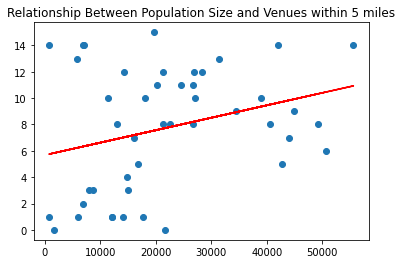

In [34]:
X = zip_df['Population'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = zip_df['Venue Count'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X, Y)
plt.title('Relationship Between Population Size and Venues within 5 miles')
plt.plot(X, Y_pred, color='red')
plt.show()

We see that there is a weak linear relationship between the total number of venues within 5 miles and the population size of a neighborhood

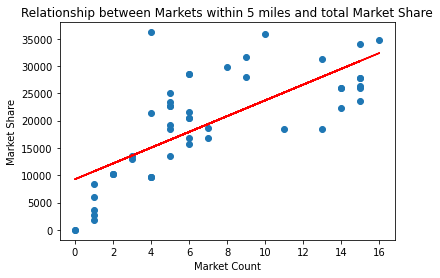

In [35]:
venue_df.plot.scatter(x='Market Count',y='Market Share', title='Relationship between Markets within 5 miles and total Market Share')
X = venue_df['Market Count'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = venue_df['Market Share'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X, Y)
plt.title('Relationship between Markets within 5 miles and total Market Share')
plt.plot(X, Y_pred, color='red')
plt.show()

,Population per Venue
count,45.00
mean,4431.21
std,4571.50
min,61.43
25%,1806.40
50%,2817.25
75%,5012.00
max,21696.00


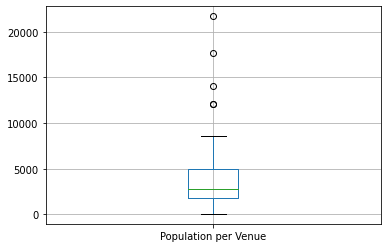

In [36]:
zip_df[['Population per Venue']].boxplot()
zip_df[['Population per Venue']].describe()

We see a stronger linear relationship between the number of markets within reach and the total Market Share.  Notice however that the two largest Market Shares go to venues with relatively few markets. 

Now we can see our current top 10 venues

In [37]:
top10_df = venue_df.sort_values('Market Share', ascending=False).head(10)
top10_df

,Short Name,Category,Latitude,Longitude,Zip Code,Market Share,Market Count
Name,,,,,,,
"PetSmart, 12812 Shops Pkwy Ste 400",PetSmart,Pet Store,30.31,-97.94,78738,36182.67,4
"Westgate Pet and Bird Hospital, 4534 West Gate Boulevard",Westgate Pet and Bird Hospital,Veterinarian,30.23,-97.80,78745,35796.34,10
"Austin Pup Culture, 606 Kenniston Dr",Austin Pup Culture,Pet Service,30.34,-97.72,78752,34776.72,16
"Taurus Academy, 6506 Burnet Rd",Taurus Academy,Pet Service,30.34,-97.74,78757,34100.38,15
"PetSmart, 11150 Research Blvd Ste 100",PetSmart,Pet Store,30.41,-97.75,78759,31579.04,9
"Allandale Veterinary Clinic, 6800 Burnet Rd #1",Allandale Veterinary Clinic,Veterinarian,30.34,-97.74,78757,31367.74,13
"Petco, 9828 Great Hills Trl #400",Petco,Pet Store,30.40,-97.75,78759,29733.67,8
"Pups & Pals, 8721 S 1st St",Pups & Pals,Pet Service,30.18,-97.80,78748,28505.87,6
"South Park Animal Hospital, 615 W Slaughter Ln #121",South Park Animal Hospital,Veterinarian,30.17,-97.80,78748,28505.87,6


### Mapping

Now that we have our full datasets, let's look at some maps that illistrate it

In [38]:
import folium # Library for geographic maps

# Map ploting functions
def get_color_hexes(length, style='hot'):
    color_map = cm.get_cmap(name=style,lut=length)
    color_list = []
    for i in range(color_map.N):
        rgba = color_map(i)
        # rgb2hex accepts rgb or rgba
        color_list.append(clr.rgb2hex(rgba))

    return color_list

def add_circle_markers(f_map, df, labels, sizes, colormap, fill=True, opacity=1):
    # If a single element is passed for labels, sizes, or colormap, apply that value to every circle.
    if isinstance(labels, (int,str,float)):
        labels = [labels] * len(df.index)
    if isinstance(sizes, (int,str,float)):
        sizes = [sizes] * len(df.index)
    if isinstance(colormap, (int,str,float)):
        colormap = [colormap] * len(df.index)
    
    for lat, lng, label, size, color in zip(df['Latitude'], df['Longitude'], labels, sizes, colormap):
        folium.CircleMarker(
            [lat, lng],
            radius=size,
            popup=folium.Popup(label, parse_html=True),
            color=color,
            fill=fill,
            fill_opacity=opacity,
            parse_html=False).add_to(f_map)

In [39]:
# Create a new folium map object, centered on Austin
top10_map = folium.Map(location=[austin_center.latitude, austin_center.longitude], zoom_start=11, control_scale=True)

# Add zip codes, scaled by their relative consumer market
labels = ["{}, Population: {}".format(code,pop) for code,pop in zip(zip_df.index,zip_df.Population)]
circle_sizes = 20 * (zip_df['Population per Venue']/zip_df['Population per Venue'].max())
add_circle_markers(f_map=top10_map, df=zip_df, labels=labels, sizes=circle_sizes, colormap='#0081cc')

# Add top 10 Venues
labels = ["{}, a {}, with a share of {:,.2f}".format(name, category, share) for name,category,share in zip(top10_df.index,top10_df['Category'],top10_df['Market Share'])]
colors = get_color_hexes(len(top10_df.index), style='hot')
add_circle_markers(f_map=top10_map, df=top10_df, labels=labels,sizes=10,colormap=colors,opacity=.5)

top10_map

#### The markers with varying color circles represent our top 10 venues, with darker colors having a bigger customer base.  The zip codes have also been resized based on the relative amount of consumers they provide per venue
Notice how the Venue with the largest market share is placed in the far east of the city, surrounded by relatively small Zip codes based on absolute population. 

We see that the number one venue (shown in black) is placed in a relatively sparsely populated location, gaining the advantage due to a lack of competition.

In [40]:
zip_map = folium.Map(location=[austin_center.latitude, austin_center.longitude], zoom_start=11, control_scale=True)

# Add zip codes, this time scaled by relative total population
labels = ["{}, Population: {}".format(code,pop) for code,pop in zip(zip_df.index,zip_df.Population)]
circle_sizes = 20 * (zip_df['Population']/zip_df['Population'].max())
add_circle_markers(f_map=zip_map, df=zip_df, labels=labels, sizes=circle_sizes, colormap='#1aabff')

# Add top 10 Venues again
add_circle_markers(f_map=zip_map, df=top10_df, labels=labels,sizes=10,colormap=colors,opacity=.5)

zip_map

### Finding the Ideal Location
Now that have an idea of what our data looks like, let's use it to calculate the best available locations.

In [41]:
import itertools #Library for fast iterations across multiple lists

To start with, we create a new column ```Population per Venue+1```, to indicate the market share a neighborhood could provide with one additional venue (ours)

In [42]:
zip_df['Population per Venue+1'] = zip_df['Population'] / (zip_df['Venue Count']+1)

Let's also create a variable to indicate the current highest market share, for use as a point of comparison.

In [43]:
max_current_market = top10_df['Market Share'].max()

#### Creating a Grid of Coordinates
Using ```np.linspace``` and ```itertools```, we create a 100 x 100 grid of points, evenly distributed across the city.

The upper and lower bounds for these coordinates are based on the maximum and minimum values for latitude and logitude across all zip codes, as logically any location beyond that bound will be less optimal than one within it given our available data and chosen metrics.

In [44]:
# grab our outer bounds
max_point = [zip_df['Latitude'].max(),zip_df['Longitude'].max()]
min_point = [zip_df['Latitude'].min(),zip_df['Longitude'].min()]
# linspace to create 100 evenly spaced latitude and longitude values
latitudes = np.linspace(max_point[0],min_point[0],100)
longitudes = np.linspace(min_point[1],max_point[1],100)
# itertools.product to create a list of every possible combination of points between those lists
point_list = list(itertools.product(latitudes, longitudes))
# convert the list into a numpy array, in preperation for using cdist
point_array = np.array(point_list)

#### Calculating a New Distance Array
As before when creating ```distance_df```, we use ```cdist``` and ```geodesic_miles``` to calculate the distance between each zip code and each point in our grid.

In [45]:
grid_array = cdist(point_array,zip_ll_array,metric=geodesic_miles)

In [46]:
grid_df = pd.DataFrame(data=grid_array,index=point_list,columns=zip_codes)

In [47]:
grid_df.head()

Zip Code,78681,78701,78702,78703,78704,78705,78712,78717,78719,78721,...,78749,78750,78751,78752,78753,78754,78756,78757,78758,78759
"(30.51578667697259, -97.9719290774269)",15.26,21.74,22.82,19.90,22.54,20.76,21.24,11.93,31.05,23.97,...,21.82,11.86,20.51,20.82,19.97,22.55,19.54,19.17,18.32,15.26
"(30.51578667697259, -97.96821457431622)",15.04,21.60,22.67,19.76,22.42,20.61,21.09,11.71,30.92,23.81,...,21.75,11.67,20.35,20.65,19.78,22.36,19.38,18.99,18.13,15.07
"(30.51578667697259, -97.96450007120553)",14.82,21.47,22.53,19.63,22.30,20.46,20.94,11.49,30.80,23.65,...,21.69,11.48,20.19,20.48,19.59,22.16,19.22,18.82,17.94,14.88
"(30.51578667697259, -97.96078556809485)",14.60,21.33,22.38,19.50,22.18,20.32,20.80,11.27,30.67,23.49,...,21.63,11.29,20.03,20.31,19.39,21.96,19.07,18.64,17.75,14.70
"(30.51578667697259, -97.95707106498416)",14.37,21.19,22.24,19.36,22.06,20.17,20.66,11.05,30.55,23.34,...,21.56,11.10,19.88,20.14,19.20,21.77,18.92,18.47,17.56,14.51


Now, we can preform the same operation as before to calculate the expected venue of each coordinate.

In [48]:
# series of the total expected value of every grid point
market_series = grid_df[grid_df<5].T.notnull().mul(zip_df['Population per Venue+1'],axis=0).sum()
market_series.shape

(10000,)

In [49]:
# items within that series who's expected value is greater than the highest current venue
market_series[market_series>max_current_market].drop_duplicates().shape

(70,)

We see there are a total of 70 distinct locations whith very high projected market shares. Let's plot them and see their distribution. 

In [50]:
top_projected = market_series[market_series>max_current_market].drop_duplicates().sort_values(ascending=False)
top_projected

(30.32101878590931, -97.69334134412547)     53352.19
(30.32476432227591, -97.68962684101479)     52121.57
(30.332255395009117, -97.6859123379041)     51665.50
(30.313527713176107, -97.68962684101479)    51301.03
(30.32101878590931, -97.6859123379041)      50070.40
                                              ...   
(30.26858127677689, -97.65248180990793)     36563.63
(30.306036640442905, -97.69334134412547)    36555.14
(30.2873089586099, -97.66362531923998)      36408.24
(30.302291104076303, -97.65619631301861)    36319.28
(30.302291104076303, -97.65248180990793)    36261.94
Length: 70, dtype: float64

In [51]:
final_map = folium.Map(location=[austin_center.latitude, austin_center.longitude], zoom_start=11, control_scale=True)

# Add zip codes
labels = ["{}, Population: {}".format(code,pop) for code,pop in zip(zip_df.index,zip_df.Population)]
circle_sizes = 20 * (zip_df['Population per Venue+1']/zip_df['Population per Venue+1'].max())
add_circle_markers(f_map=final_map, df=zip_df, labels=labels, sizes=circle_sizes, colormap='#1aabff')

# Add Ideal Venue
for point in top_projected.index:
    folium.Marker([point[0], point[1]], popup=str(point)).add_to(final_map)

final_map

## Results and Discussion <a name="results"></a>

Our analysis showed the distribution of supply and demand across Austin, and how despite the number of existing venues areas still exist that represent underserved markets.  

We used distance matrices measured by geodesic distance to determine the potential market of each neighborhood, in order to weigh our market calcuations against the possible competition. We then created a grid of theoretical venue locations and preformed the same calcutions to measure the value of each one.

We found there are 70 distinct locations which offer high level of value, and all of them are clustered around the US290 intersection wih US183. In particular all values fall within 5 miles of 78724, the largest neighborhood which currently has no venues within convenient reach.  

Based on these results, my best recomendation for locating the new business is **near the US290/183 Intersection**

## Conclusion  <a name="conclusion"></a>

In this notebook we analyzed the ideal location to maximize potential customer base.  The final decision of optimal location will be reached through exploring additional criteria, and these results can be used to narrow down future analysis to the most promising regions. 